In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from numba import jit
from tvtk.tools import visual
from scipy import interpolate
import math
from numpy import unravel_index
import pickle
from datalib import Data
aberration=False
from mayavi import mlab
from scipy.interpolate import griddata

In [2]:
T = 4.166
omega = 2*np.pi/T

R = 1
r_em = 3.0
ini_ph = 4.21

N1 = 400
N2 = 400
N3 = 400

w=20
xa = np.linspace(-w,w,N1)
ya = np.linspace(-w,w,N2)
za = np.linspace(-w,w,N3)
center = int(N1/2.0)

px = 0.0
py = 0.985
pz = 0.174

In [3]:
#the angle between the magnetic moment axis and the rotation axis
alpha = 80*np.pi/180.0

#the angle between the rotation axis and the observer 
delta = 77*np.pi/180.0

#@jit(parallel=True)
def cal_m(phi):
    phi = phi+ini_ph
    m_x = np.sin(alpha)*np.cos(delta)*np.cos(phi)-np.sin(delta)*np.cos(alpha)
    m_y = np.sin(alpha)*np.sin(phi)
    m_z = np.cos(alpha)*np.cos(delta) + np.sin(alpha)*np.sin(delta)*np.cos(phi)
    return m_x,m_y,m_z
  
@jit(parallel=True)
def cal_bfield(phi_new, th_em, phi_em, r_em, h):
    x_ray = r_em*np.sin(th_em)*np.cos(phi_em)
    y_ray = r_em*np.sin(th_em)*np.sin(phi_em)
    z_ray = r_em*np.cos(th_em) + h
    #x_ray = np.cos(phi_new)*(x0*np.cos(delta) + z0*np.sin(delta))+np.sin(phi_new)*y0
    #y_ray = -np.sin(phi_new)*(np.cos(delta)*x0 + np.sin(delta)*z0)+ np.cos(phi_new)*y0
    #z_ray = -x0*np.sin(delta) + z0*np.cos(delta)
    m_x, m_y, m_z = cal_m(phi_new)
    r = np.sqrt(x_ray**2 + y_ray**2 + z_ray**2)
    B_y = (-m_y/r**3 + 3*y_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_x = (-m_x/r**3 + 3*x_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_z = (-m_z/r**3 + 3*z_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag

@jit(parallel=True)
def get_emission_point_dip(m_x,m_y,m_z):
    th_em = np.arccos(m_z)/2.0 - 0.5*np.arcsin(0.33*np.sin(np.arccos(m_z)))
    phi_em = np.arctan(m_y/m_x)
    return th_em, phi_em

@jit(parallel=True)
def get_bfield(x,y,z,phi):
    m_x, m_y, m_z = cal_m(phi)
    r = np.sqrt(x**2 + y**2 + z**2)
    B_y = (-m_y/r**3 + 3*y*(m_x*x + m_y*y + m_z*z)/r**5)
    B_x = (-m_x/r**3 + 3*x*(m_x*x + m_y*y + m_z*z)/r**5)
    B_z = (-m_z/r**3 + 3*z*(m_x*x + m_y*y + m_z*z)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag, B_z/Bmag

@jit(parallel=True)
def get_field(x0,y0,z0,t):
    x = np.cos(omega*t)*(x0*np.cos(delta) + z0*np.sin(delta))+np.sin(omega*t)*y0
    y = -np.sin(omega*t)*(np.cos(delta)*x0 + np.sin(delta)*z0)+ np.cos(omega*t)*y0
    z = -x0*np.sin(delta) + z0*np.cos(delta)
    r1 = np.sqrt(x**2+y**2+z**2)
    r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
    rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
    #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4)) + (z+0.4)*(-2*y+0.2*(z+0.4))
    bxd = R**3*(-px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5)
    byd = R**3*(-py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5)
    bzd = R**3*(-pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5)
    bxq = R**4*(-2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7)
    byq = R**4*(-2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7)
    bzq = R**4*(-2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7)
    bx = bxd
    by = byd
    bz = bzd
    Bx = np.cos(delta)*np.cos(omega*t)*bx - np.cos(delta)*np.sin(omega*t)*by-np.sin(delta)*bz
    By = np.sin(omega*t)*bx + np.cos(omega*t)*by
    Bz = np.sin(delta)*np.cos(omega*t)*bx - np.sin(delta)*np.sin(omega*t)*by + np.cos(delta)*bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    return Bx/Bmag, By/Bmag, Bz/Bmag

@jit(parallel=True)
def get_field2(x0,y0,z0,t):
    x = np.cos(omega*t)*x0+np.sin(omega*t)*y0
    y = -np.sin(omega*t)*x0+ np.cos(omega*t)*y0
    z = z0
    r1 = np.sqrt(x**2+y**2+z**2)
    r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
    rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
    #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4)) + (z+0.4)*(-2*y+0.2*(z+0.4))
    bxd = R**3*(-px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5)
    byd = R**3*(-py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5)
    bzd = R**3*(-pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5)
    bxq = R**4*(-2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7)
    byq = R**4*(-2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7)
    bzq = R**4*(-2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7)
    bx = bxd
    by = byd
    bz = bzd
    Bx = np.cos(omega*t)*bx - np.sin(omega*t)*by
    By = np.sin(omega*t)*bx + np.cos(omega*t)*by
    Bz = bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    return Bx/Bmag, By/Bmag, Bz/Bmag


def cal_PA_dip(h,r_em,T):
    c = 3e10
    t_ray = h*1e3/c
    t = 0
    dt = 0.1
    Rl = c*T*1e-3/2/np.pi
    PA, phase = [],[]
    phi = 0
    while phi<2*np.pi:
        phi = omega*t
        m_x, m_y, m_z = cal_m(phi)
        th_em, phi_em = get_emission_point_dip(m_x,m_y,m_z)
        B_x, B_y = cal_bfield(phi + 2*np.pi*t_ray/T, th_em, phi_em, r_em, h)
        Psi = np.arctan(B_y/B_x)
        PA.append(Psi)
        phase.append((phi+ini_ph)%(2*np.pi))
        t += dt
    PA = np.array(PA)*180/np.pi
    phase = np.array(phase)*180/np.pi
    return phase,PA

In [4]:
ph_dip,pa_dip = cal_PA_dip(1e5,r_em,T)

/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_33279/2554381095.py", line 31:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_33279/2554381095.py:15: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_bfield" failed type inference due to: Untyped global name 'cal_m': Cannot determine Numba type of <class 'function'>

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_33279/2554381095.py", line 23:
<source missing, REPL/exec in use

In [5]:
ids1 = np.where(ph_dip>180)[0]
ph_dip[ids1] = -360+ph_dip[ids1]

def rescale(vec):
    vec = (vec+ini_ph*180/np.pi)%(360)
    ids = np.where(vec>180)[0]
    vec[ids] = -360+vec[ids]
    return vec

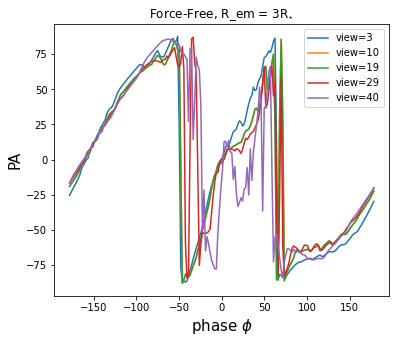

In [12]:
#ph_ar1, pa_vc_3 = np.genfromtxt('RT_VC_3_3.txt',unpack=True)
ph_ar1, pa_ff_1 = np.genfromtxt('RT_FF_3_3.txt',unpack=True)
ph_ar2, pa_ff_2 = np.genfromtxt('RT_FF_19_3.txt',unpack=True)
ph_ar3, pa_ff_3 = np.genfromtxt('RT_FF_19_3.txt',unpack=True)
ph_ar4, pa_ff_4 = np.genfromtxt('RT_FF_29_3.txt',unpack=True)
ph_ar5, pa_ff_5 = np.genfromtxt('RT_FF_40_3.txt',unpack=True)
#ph_ar2, ana_vc_47_8 = np.genfromtxt('Ana_VC_47_8.txt',unpack=True)
#ph_ar2 = rescale(ph_ar2)
plt.figure(figsize=(6,5))
#plt.scatter(ph_dip,pa_dip,label='Dip Analytical')
#plt.scatter(ph_ar1,pa_vc_3*180/np.pi,label="Vac,dip",c='k',s=4)
plt.plot(ph_ar1,pa_ff_1*180/np.pi,label="view=3")
plt.plot(ph_ar2,pa_ff_2*180/np.pi,label="view=10")
plt.plot(ph_ar3,pa_ff_3*180/np.pi,label="view=19")
plt.plot(ph_ar4,pa_ff_4*180/np.pi,label="view=29")
plt.plot(ph_ar5,pa_ff_5*180/np.pi,label="view=40")
plt.title(r"Force-Free, R_em = 3R$_{\star}$")
plt.xlabel(r'phase $\phi$',size=15)
plt.ylabel(r'PA',size=15)
plt.legend()
plt.savefig('comparison_view.png')
plt.show()

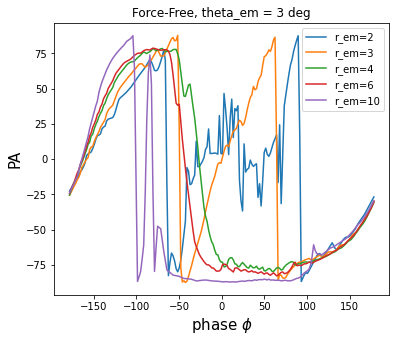

In [17]:
ph_ar1, pa_ff_1 = np.genfromtxt('RT_FF_3_2.txt',unpack=True)
ph_ar2, pa_ff_2 = np.genfromtxt('RT_FF_3_3.txt',unpack=True)
ph_ar3, pa_ff_3 = np.genfromtxt('RT_FF_3_4.txt',unpack=True)
ph_ar4, pa_ff_4 = np.genfromtxt('RT_FF_3_6.txt',unpack=True)
ph_ar5, pa_ff_5 = np.genfromtxt('RT_FF_3_10.txt',unpack=True)
plt.figure(figsize=(6,5))
plt.plot(ph_ar1,pa_ff_1*180/np.pi,label="r_em=2")
plt.plot(ph_ar2,pa_ff_2*180/np.pi,label="r_em=3")
plt.plot(ph_ar3,pa_ff_3*180/np.pi,label="r_em=4")
plt.plot(ph_ar4,pa_ff_4*180/np.pi,label="r_em=6")
plt.plot(ph_ar5,pa_ff_5*180/np.pi,label="r_em=10")
plt.title(r"Force-Free, theta_em = 3 deg")
plt.xlabel(r'phase $\phi$',size=15)
plt.ylabel(r'PA',size=15)
plt.legend()
plt.savefig('comparison_rem.png')
plt.show()

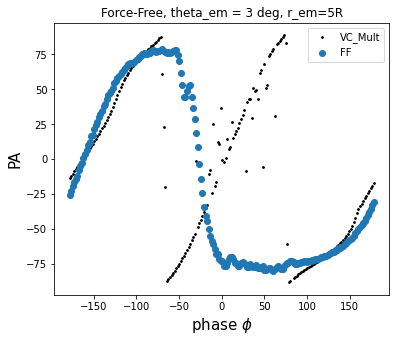

In [24]:
ph_ar1, pa_ff_1 = np.genfromtxt('RT_VCM_3_5.txt',unpack=True)
ph_ar2, pa_ff_2 = np.genfromtxt('RT_FF_3_5.txt',unpack=True)
plt.figure(figsize=(6,5))
plt.scatter(ph_ar1,pa_ff_1*180/np.pi,label="VC_Mult",s=3,c='k')
plt.scatter(ph_ar2,pa_ff_2*180/np.pi,label="FF")
plt.title(r"Force-Free, theta_em = 3 deg, r_em=5R")
plt.xlabel(r'phase $\phi$',size=15)
plt.ylabel(r'PA',size=15)
plt.legend()
plt.savefig('comparison_FFVCM.png')
plt.show()

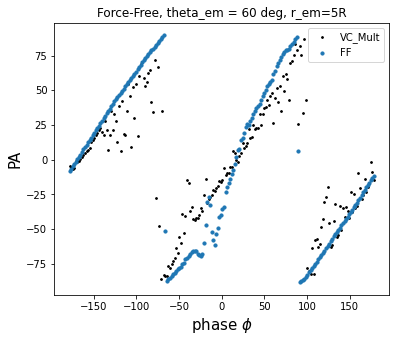

In [27]:
ph_ar1, pa_ff_1 = np.genfromtxt('RT_VCM_60_5.txt',unpack=True)
ph_ar2, pa_ff_2 = np.genfromtxt('RT_FF_60_5.txt',unpack=True)
plt.figure(figsize=(6,5))
plt.scatter(ph_ar1,pa_ff_1*180/np.pi,label="VC_Mult",s=3,c='k')
plt.scatter(ph_ar2,pa_ff_2*180/np.pi,label="FF",s=10)
plt.title(r"Force-Free, theta_em = 60 deg, r_em=5R")
plt.xlabel(r'phase $\phi$',size=15)
plt.ylabel(r'PA',size=15)
plt.legend()
plt.savefig('comparison_FFVCM_v60.png')
plt.show()